In [518]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,GRU, Input, ConvLSTM2D, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import math
from IPython.core.pylabtools import figsize
figsize(15, 7) 

#dataset_train = pd.read_csv('./dataset/THGBNKLAK1TS301_Memory Used (percentage)_Oct_2020.csv')  # 讀取訓練集
dataset_train = pd.read_csv('./dataset/ATKH_Oplus_TWGKHHPSK1MSB04_memory_usage_2020_10.csv')
dataset_train2 = pd.read_csv('./dataset/ATKH_Oplus_TWGKHHPSK1MSB04_memory_usage_2020_11.csv')# 讀取訓練集
#dataset_train = dataset_train.dropna(axis=0)
dataset_train = dataset_train2.append(dataset_train) 
dataset_train = dataset_train[::-1].reset_index(drop=True) 

train_count = int(len(dataset_train)*0.8)
test_count = len(dataset_train)-train_count
training_set = (dataset_train.iloc[:train_count, 3:4].values) # 取「Open」欄位值

#dataset_test = pd.read_csv('./dataset/ATBK_test.csv')
testing_set = (dataset_train.iloc[train_count:, 3:4].values)

#dataset_total = pd.concat((dataset_train['Value'], dataset_test['Value']), axis = 0)
#inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
#inputs = inputs.reshape(-1,1)
#inputs = sc.transform(inputs) # Feature Scaling


In [525]:
dataset_train.shape

(29276, 4)

In [520]:
testing_set.shape

(5856, 1)

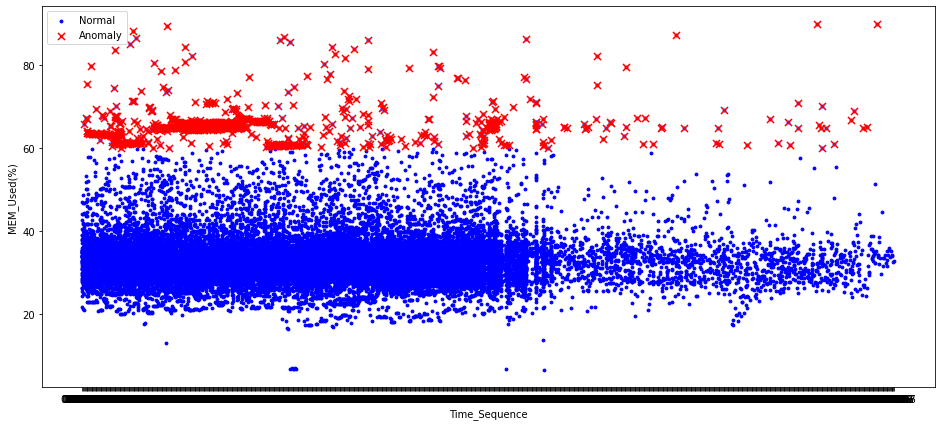

In [521]:
def prepare_plot(data_frame):
    
    plt.scatter(data_frame['time'],
               data_frame['%used'], s=8, color='blue',label='Normal')

    labled_anomalies = data_frame.loc[data_frame['%used'] >= 60, ['time', '%used']]
    plt.scatter(labled_anomalies['time'],
               labled_anomalies['%used'], s=50,marker='x',color='red',label='Anomaly')
    
    plt.ylabel('MEM_Used(%)')
    plt.xlabel('Time_Sequence')
    plt.legend()
    

    return plt


figsize(16, 7)
prepare_plot(dataset_train)



plt.show()


In [522]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler,RobustScaler


#MinMaxScaler


#sc_train = MinMaxScaler(feature_range = (0, 1))
#training_set_scaled = sc_train.fit_transform(training_set)

#sc_test = MinMaxScaler(feature_range = (0, 1))
#testing_set_scaled = sc_test.fit_transform(testing_set)


#RobustScaler

sc_train = RobustScaler()
training_set_scaled = sc_train.fit_transform(training_set)

sc_test = RobustScaler()
testing_set_scaled = sc_test.fit_transform(testing_set)

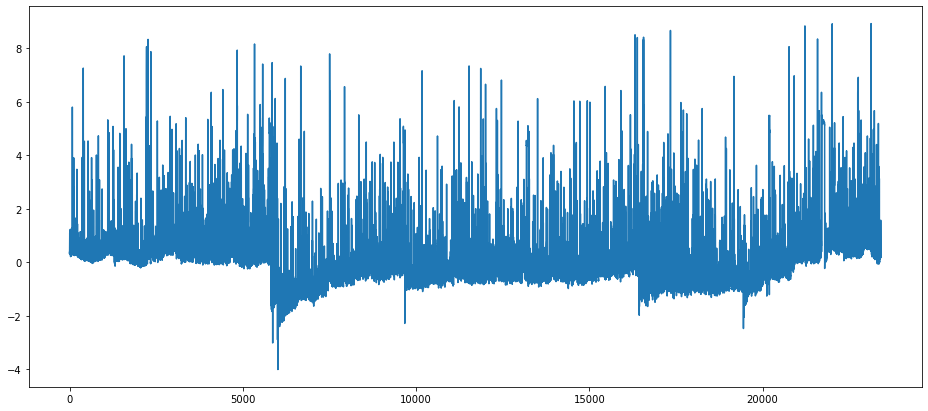

In [524]:
plt.plot(training_set_scaled)

In [526]:
def gen_dataset(data,x_window_size,y_window_size):
    X_train = []   #預測點的前 60 天的資料
    y_train = []   #預測點
    for i in range(x_window_size, data.shape[0]-y_window_size,y_window_size):
        X_train.append(data[i-x_window_size:i, 0])
        y_train.append(data[i:i+y_window_size, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    
    return X_train,y_train
    
X_train,y_train = gen_dataset(training_set_scaled,60,1)
X_test,y_test = gen_dataset(testing_set_scaled,60,1)

In [527]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(23359, 60, 1)
(23359, 1)
(5795, 60, 1)
(5795, 1)


In [528]:
from keras.callbacks import ReduceLROnPlateau

rp = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=0.0001, 
    cooldown=0, 
    min_lr=0
)


In [529]:
model = Sequential()
model.add(GRU(60, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True,unroll=True,activation='relu'))

model.add(GRU(60, return_sequences=False,unroll=True,activation='relu'))

model.add(Dense(y_train.shape[1]))

model.compile(loss="mae", optimizer="adam")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_21 (GRU)                 (None, 60, 60)            11160     
_________________________________________________________________
gru_22 (GRU)                 (None, 60)                21780     
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 61        
Total params: 33,001
Trainable params: 33,001
Non-trainable params: 0
_________________________________________________________________


In [531]:
EPOCH = 70
BATCH = 128

In [532]:
history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH, validation_split=0.2,callbacks=[rp],shuffle=False,verbose=1)

Train on 21023 samples, validate on 2336 samples
Epoch 1/100
21023/21023 [==============================] - 203s 10ms/step - loss: 0.5140 - val_loss: 0.4457
Epoch 2/100
21023/21023 [==============================] - 26s 1ms/step - loss: 0.4534 - val_loss: 0.4484
Epoch 3/100
21023/21023 [==============================] - 26s 1ms/step - loss: 0.4461 - val_loss: 0.4204
Epoch 4/100
21023/21023 [==============================] - 25s 1ms/step - loss: 0.4395 - val_loss: 0.4178
Epoch 5/100
21023/21023 [==============================] - 25s 1ms/step - loss: 0.4364 - val_loss: 0.4119
Epoch 6/100
21023/21023 [==============================] - 25s 1ms/step - loss: 0.4333 - val_loss: 0.3957
Epoch 7/100
21023/21023 [==============================] - 26s 1ms/step - loss: 0.4348 - val_loss: 0.4056
Epoch 8/100
21023/21023 [==============================] - 25s 1ms/step - loss: 0.4321 - val_loss: 0.4307
Epoch 9/100
21023/21023 [==============================] - 25s 1ms/step - loss: 0.4327 - val_loss: 0.

21023/21023 [==============================] - 26s 1ms/step - loss: 0.4078 - val_loss: 0.3813
Epoch 77/100
21023/21023 [==============================] - 25s 1ms/step - loss: 0.4078 - val_loss: 0.3871
Epoch 78/100
21023/21023 [==============================] - 26s 1ms/step - loss: 0.4077 - val_loss: 0.3819
Epoch 79/100
21023/21023 [==============================] - 26s 1ms/step - loss: 0.4077 - val_loss: 0.3866
Epoch 80/100
21023/21023 [==============================] - 26s 1ms/step - loss: 0.4075 - val_loss: 0.3815
Epoch 81/100
21023/21023 [==============================] - 26s 1ms/step - loss: 0.4076 - val_loss: 0.3867
Epoch 82/100
21023/21023 [==============================] - 26s 1ms/step - loss: 0.4074 - val_loss: 0.3814
Epoch 83/100
21023/21023 [==============================] - 26s 1ms/step - loss: 0.4075 - val_loss: 0.3867
Epoch 84/100
21023/21023 [==============================] - 26s 1ms/step - loss: 0.4072 - val_loss: 0.3811
Epoch 85/100
21023/21023 [========================

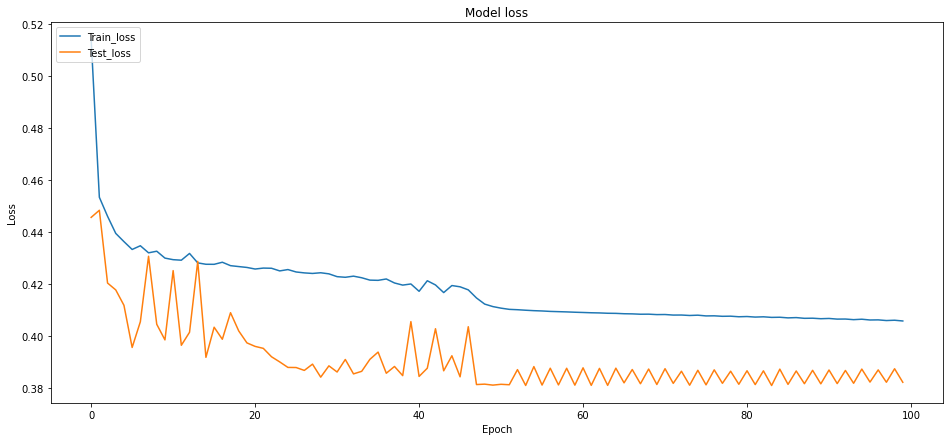

In [533]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_loss', 'Test_loss'], loc='upper left')
plt.show()

In [534]:
predicted_traffic = model.predict(X_test)



#predicted_traffic = sc_train.inverse_transform(predicted_traffic)  # to get the original scale
predicted_traffic = sc_test.inverse_transform(predicted_traffic) 

#plot_predicted_traffic = np.reshape(predicted_traffic,(-1,1))

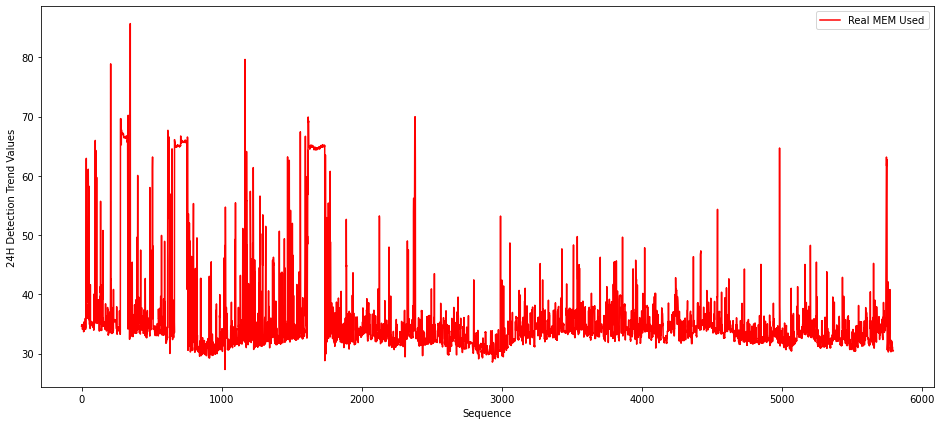

In [660]:
show_data_count = 0

plt.plot(testing_set[:predicted_traffic.shape[0]-show_data_count],color = 'red', label = 'Real MEM Used')
#plt.plot(predicted_traffic,color = 'blue', label = 'Predicted MEM Used')

#plt.axhline(y=60, xmin=0, xmax=predicted_traffic.shape[0],label = 'upper')
#plt.axhline(y=30, xmin=0, xmax=predicted_traffic.shape[0],label = 'low')
plt.xlabel('Sequence')
plt.ylabel('24H Detection Trend Values')
plt.legend()

In [537]:
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import mean_absolute_error
from  datetime import datetime

now_time = datetime.now()     #獲取當前時間
now_time = now_time.strftime('%Y%m%d_%H%M%S')   #列印需要的資訊,依次是年月日,時分秒,注意字母大小寫
print ("Result:\n")

print("-------------------------------")

MAEScore = mean_absolute_error(testing_set[:predicted_traffic.shape[0]],predicted_traffic)
RMSEScore = math.sqrt(mean_squared_error(testing_set[:predicted_traffic.shape[0]],predicted_traffic))

print('Test Score: %.2f MAE' % (MAEScore))
print('Test Score: %.2f RMSE' % (RMSEScore))


anomaly_index = dataset_test.loc[dataset_test['%used'] >= 60, ['time', '%used']].index
anomaly_value = dataset_test.loc[dataset_test['%used'] >= 60, ['%used']].values
anomaly_MAEScore = mean_absolute_error(predicted_traffic[anomaly_index],anomaly_value)
anomaly_RMSEScore = math.sqrt(mean_squared_error(predicted_traffic[anomaly_index],anomaly_value))


print('Anomaly_Test Score: %.2f MAE' % (anomaly_MAEScore))
print('Anomaly_Test Score: %.2f RMSE' % (anomaly_RMSEScore))

print("-------------------------------")

from keras.utils import plot_model
plot_model(model, to_file='./model_plot/GRU_NovDec_model.png',show_shapes=True)
model.save("./model/%s_MEM_used_stack_LSTM_%.2fMAE_%.2fRMSE.h5"%(now_time,MAEScore,RMSEScore))

Result:

-------------------------------
Test Score: 3.88 MAE
Test Score: 8.05 RMSE
Anomaly_Test Score: 34.83 MAE
Anomaly_Test Score: 36.69 RMSE
-------------------------------


In [642]:
log_data[:,3:4].shape

(60, 1)

In [617]:
print(log_data.shape)
log_data = np.expand_dims(log_data, axis=0)
print(log_data.shape)

(60, 4)
(1, 60, 4)


In [638]:
log_data[0][:,3:4].shape

(60, 1)

In [653]:
log_data

array([['2020/10/1', '00:00:45', 1601481645, 34.8176],
       ['2020/10/5', '14:21:45', 1601878905, 42.5579],
       ['2020/10/5', '14:24:45', 1601879085, 44.2892],
       ['2020/10/5', '14:27:45', 1601879265, 51.521],
       ['2020/10/5', '14:30:45', 1601879445, 48.1685],
       ['2020/10/5', '14:33:45', 1601879625, 55.2114],
       ['2020/10/5', '14:36:45', 1601879805, 50.0479],
       ['2020/10/5', '14:39:45', 1601879985, 48.8265],
       ['2020/10/5', '14:42:45', 1601880165, 67.5577],
       ['2020/10/5', '14:45:45', 1601880345, 52.657],
       ['2020/10/5', '14:48:45', 1601880525, 52.6062],
       ['2020/10/5', '14:51:45', 1601880705, 76.6847],
       ['2020/10/5', '14:54:45', 1601880885, 44.9174],
       ['2020/10/5', '14:57:45', 1601881065, 49.8594],
       ['2020/10/5', '15:00:45', 1601881245, 78.0155],
       ['2020/10/5', '15:03:45', 1601881425, 45.7945],
       ['2020/10/5', '15:06:45', 1601881605, 55.4534],
       ['2020/10/5', '15:09:45', 1601881785, 84.5176],
       ['202

In [654]:
log_data[-1][0]

array(['2020/10/5', '17:15:46', 1601889346, 82.2678], dtype=object)

In [651]:
DATETIME = dt.strptime(log_data[-1][0]+'_'+log_data[-1][1],"%Y/%m/%d_%H:%M:%S")

In [648]:
log_data[-1][3]

AttributeError: 'float' object has no attribute 'shape'

In [673]:
from datetime import datetime as dt
from datetime import timedelta
#datetime.strptime("2018-01-31", "%Y-%m-%d")

log_data = dataset_train.iloc[:60].values
mem_data = dataset_train.iloc[:60,3:4].values
for i in range(60,dataset_train.shape[0],1):
    log_data = np.append(log_data,dataset_train.iloc[i:i+1].values,axis=0)
    log_data = np.delete(log_data,1,axis=0)
    DATETIME = dt.strptime(log_data[-1][0]+'_'+log_data[-1][1],"%Y/%m/%d_%H:%M:%S")
    sample = log_data[:,3:4]
    pred_scaler = RobustScaler()
    sample_scaled = pred_scaler.fit_transform(sample)
    
    sample_scaled = np.expand_dims(sample_scaled,axis=0)
    

    
    
    pred_data = model.predict(sample_scaled)
    pred_data = pred_scaler.inverse_transform(pred_data)
    diff = log_data[-1][3]-pred_data
    if abs(diff)  >= 30 or pred_data >= 60 :
        anomaly_time = DATETIME+timedelta(minutes=3)
        print("\nPredict anomaly time : "+anomaly_time.strftime("%Y/%m/%d_%H:%M:%S"))
        print("Anomaly value : {}".format(log_data[-1][3]) )
        with open('./anomaly_log_file/anomaly_data5.txt', 'a') as f:
            f.write("[{}]{}".format(anomaly_time.strftime("%Y/%m/%d_%H:%M:%S"),log_data[-1][3]))
            f.write("\n")
    """
pred_data = model.predict(mem_data)
diff = mem_data[0][-1][0]-pred_data
if abs(diff) >= 30:
    print(diff)
DATETIME = dt.strptime(log_data[-1][0]+'_'+log_data[-1][1],"%Y/%m/%d_%H:%M:%S")
print(DATETIME)
#TIME = datetime.strptime(log_data[-1][1],"%H:%M:%S")
#log_data[-1][0]+'_'+log_data[-1][1]
DATETIME+timedelta(minutes=3)
"""


Predict anomaly time : 2020/10/01_04:06:45
Anomaly value : 69.9231

Predict anomaly time : 2020/10/01_19:51:45
Anomaly value : 79.3443

Predict anomaly time : 2020/10/04_06:42:45
Anomaly value : 82.3043

Predict anomaly time : 2020/10/05_15:12:45
Anomaly value : 84.5176

Predict anomaly time : 2020/10/05_16:00:45
Anomaly value : 81.8726

Predict anomaly time : 2020/10/05_17:18:46
Anomaly value : 82.2678

Predict anomaly time : 2020/10/05_17:21:45
Anomaly value : 86.2808

Predict anomaly time : 2020/10/05_21:18:45
Anomaly value : 72.2942

Predict anomaly time : 2020/10/05_21:21:45
Anomaly value : 83.32799999999999

Predict anomaly time : 2020/10/09_12:30:45
Anomaly value : 73.4969

Predict anomaly time : 2020/10/10_05:15:45
Anomaly value : 74.1604

Predict anomaly time : 2020/10/11_01:57:45
Anomaly value : 74.5075

Predict anomaly time : 2020/10/11_02:00:45
Anomaly value : 83.6881

Predict anomaly time : 2020/10/11_02:03:45
Anomaly value : 66.7407

Predict anomaly time : 2020/10/11_02:


Predict anomaly time : 2020/10/28_12:36:45
Anomaly value : 60.7058

Predict anomaly time : 2020/10/28_12:39:45
Anomaly value : 60.7624

Predict anomaly time : 2020/10/28_12:42:45
Anomaly value : 60.8057

Predict anomaly time : 2020/10/28_12:45:46
Anomaly value : 60.7749

Predict anomaly time : 2020/10/28_12:48:45
Anomaly value : 60.9015

Predict anomaly time : 2020/10/28_12:51:45
Anomaly value : 60.8527

Predict anomaly time : 2020/10/28_12:54:45
Anomaly value : 60.93899999999999

Predict anomaly time : 2020/10/28_12:57:46
Anomaly value : 60.8896

Predict anomaly time : 2020/10/28_13:00:45
Anomaly value : 60.5904

Predict anomaly time : 2020/10/28_13:03:45
Anomaly value : 60.8615

Predict anomaly time : 2020/10/28_13:06:45
Anomaly value : 60.8957

Predict anomaly time : 2020/10/28_13:09:45
Anomaly value : 60.8382

Predict anomaly time : 2020/10/28_13:12:45
Anomaly value : 60.8849

Predict anomaly time : 2020/10/28_13:15:45
Anomaly value : 60.8799

Predict anomaly time : 2020/10/28_13:


Predict anomaly time : 2020/11/15_08:15:45
Anomaly value : 66.3847

Predict anomaly time : 2020/11/15_08:18:45
Anomaly value : 66.3321

Predict anomaly time : 2020/11/15_08:21:45
Anomaly value : 66.3301

Predict anomaly time : 2020/11/15_08:24:45
Anomaly value : 66.2788

Predict anomaly time : 2020/11/15_08:27:45
Anomaly value : 66.3799

Predict anomaly time : 2020/11/15_08:30:45
Anomaly value : 66.0618

Predict anomaly time : 2020/11/15_08:33:45
Anomaly value : 66.03699999999999

Predict anomaly time : 2020/11/15_08:36:45
Anomaly value : 66.021

Predict anomaly time : 2020/11/15_08:39:45
Anomaly value : 65.969

Predict anomaly time : 2020/11/15_08:42:45
Anomaly value : 66.0099

Predict anomaly time : 2020/11/15_08:45:45
Anomaly value : 66.0859

Predict anomaly time : 2020/11/15_08:48:45
Anomaly value : 65.9549

Predict anomaly time : 2020/11/15_08:51:45
Anomaly value : 66.0196

Predict anomaly time : 2020/11/15_08:54:45
Anomaly value : 65.9081

Predict anomaly time : 2020/11/15_08:57


Predict anomaly time : 2020/11/20_06:09:45
Anomaly value : 64.9065

Predict anomaly time : 2020/11/20_06:12:45
Anomaly value : 64.9325

Predict anomaly time : 2020/11/20_06:15:45
Anomaly value : 65.0927

Predict anomaly time : 2020/11/20_06:18:45
Anomaly value : 64.8939

Predict anomaly time : 2020/11/20_06:21:45
Anomaly value : 64.9389

Predict anomaly time : 2020/11/20_06:24:45
Anomaly value : 64.9558

Predict anomaly time : 2020/11/20_06:27:45
Anomaly value : 65.0033

Predict anomaly time : 2020/11/20_06:30:45
Anomaly value : 65.0078

Predict anomaly time : 2020/11/20_06:33:45
Anomaly value : 65.1583

Predict anomaly time : 2020/11/20_06:36:45
Anomaly value : 65.0449

Predict anomaly time : 2020/11/20_06:39:45
Anomaly value : 66.7187

Predict anomaly time : 2020/11/20_06:42:45
Anomaly value : 65.6446

Predict anomaly time : 2020/11/20_06:45:45
Anomaly value : 65.4781

Predict anomaly time : 2020/11/20_06:48:45
Anomaly value : 65.5707

Predict anomaly time : 2020/11/20_06:51:45
Anom

Predict anomaly time : 2020/11/22_07:15:46
Anomaly value : 64.5544

Predict anomaly time : 2020/11/22_07:18:45
Anomaly value : 64.6987

Predict anomaly time : 2020/11/22_07:21:45
Anomaly value : 64.5231

Predict anomaly time : 2020/11/22_07:24:45
Anomaly value : 64.5014

Predict anomaly time : 2020/11/22_07:27:46
Anomaly value : 64.5089

Predict anomaly time : 2020/11/22_07:30:45
Anomaly value : 64.5132

Predict anomaly time : 2020/11/22_07:33:45
Anomaly value : 64.5515

Predict anomaly time : 2020/11/22_07:36:45
Anomaly value : 64.6841

Predict anomaly time : 2020/11/22_07:39:45
Anomaly value : 64.7453

Predict anomaly time : 2020/11/22_07:42:45
Anomaly value : 64.7113

Predict anomaly time : 2020/11/22_07:45:45
Anomaly value : 64.7574

Predict anomaly time : 2020/11/22_07:48:45
Anomaly value : 64.5697

Predict anomaly time : 2020/11/22_07:51:45
Anomaly value : 64.6914

Predict anomaly time : 2020/11/22_07:54:45
Anomaly value : 64.8326

Predict anomaly time : 2020/11/22_07:57:45
Anoma

In [ ]:
temp_date = ""
anomaly_date_list = []
for i in range(X_data.shape[0]):
    
    
    pred_data = sc.inverse_transform(X_data[i])
    max_value = np.max(pred_data)
    if max_value >= 250 and time[i,np.argmax(pred_data)] != temp_date:
        anomaly_date_list.append(time[i,np.argmax(pred_data)])
        max_index = np.argmax(pred_data)
        print("Time : {}\nAnomaly Value : {}\n".format(time[i,max_index],max_value))
        with open('./anomaly_log_file/anomaly_data4.txt', 'a') as f:
            f.write("[{}]{}".format(time[i,max_index],max_value))
            f.write("\n")
        print(temp_date)
    temp_date = time[i,np.argmax(pred_data)]

In [558]:

for i in range(dataset_train.shape[0]-22000):
    offset = abs(dataset_train.iloc[i:i+1,3:4].values-dataset_train.iloc[i+1:i+2,3:4].values)
    if offset >= 30:
        print(offset)


[[30.3297]]
[[33.8129]]
[[37.4568]]
[[30.4398]]
[[44.1987]]
[[45.9671]]
[[31.2369]]
[[31.7673]]
[[32.221]]
[[42.7216]]
[[38.6737]]
[[33.6266]]
[[32.96]]
[[35.2199]]
[[37.8728]]
[[40.6086]]
[[41.0429]]
[[41.344]]
[[32.8271]]
[[31.7327]]
[[30.985]]
[[30.9337]]
[[31.7015]]
[[34.9062]]
[[32.6988]]
[[38.2328]]
[[32.2525]]
[[32.3809]]
[[34.6304]]
[[35.0075]]
[[31.4073]]
[[41.3311]]
[[48.2832]]
[[36.2897]]
[[32.8026]]
[[46.7473]]
[[36.9176]]
[[33.753]]
[[44.4563]]
[[52.3242]]
[[30.533]]
[[36.3934]]
[[30.3645]]
[[32.2873]]
[[34.1858]]
[[35.1333]]
[[46.9133]]
[[37.5192]]
[[33.7818]]
[[38.9832]]
[[48.5398]]
[[36.311]]
[[31.5664]]


In [538]:
anomaly_index = dataset_test.loc[dataset_test['%used'] >= 60, ['time', '%used']].index
anomaly_value = dataset_test.loc[dataset_test['%used'] >= 60, ['%used']].values

for i in anomaly_index:
    print(i)
    anomaly_MAEScore = mean_absolute_error(predicted_traffic[i],dataset_test.iloc[i:i+1,4:5].values)
    anomaly_RMSEScore = math.sqrt(mean_squared_error(predicted_traffic[i],dataset_test.iloc[i:i+1,4:5].values))


    #print('Anomaly_Test Score: %.2f MAE' % (anomaly_MAEScore))
    print('Anomaly_Test Score: %.2f RMSE' % (anomaly_RMSEScore))
    
    

18
Anomaly_Test Score: 29.47 RMSE
22
Anomaly_Test Score: 28.11 RMSE
70
Anomaly_Test Score: 32.25 RMSE
441
Anomaly_Test Score: 30.17 RMSE
629
Anomaly_Test Score: 22.00 RMSE
630
Anomaly_Test Score: 11.02 RMSE
664
Anomaly_Test Score: 1.78 RMSE
709
Anomaly_Test Score: 53.08 RMSE
710
Anomaly_Test Score: 48.97 RMSE
715
Anomaly_Test Score: 26.52 RMSE
722
Anomaly_Test Score: 41.03 RMSE
723
Anomaly_Test Score: 38.67 RMSE
726
Anomaly_Test Score: 48.83 RMSE
728
Anomaly_Test Score: 35.24 RMSE
730
Anomaly_Test Score: 33.79 RMSE
732
Anomaly_Test Score: 41.71 RMSE
733
Anomaly_Test Score: 40.88 RMSE
735
Anomaly_Test Score: 31.53 RMSE
736
Anomaly_Test Score: 49.87 RMSE
752
Anomaly_Test Score: 54.06 RMSE
755
Anomaly_Test Score: 46.21 RMSE
758
Anomaly_Test Score: 45.91 RMSE
761
Anomaly_Test Score: 36.90 RMSE
1186
Anomaly_Test Score: 27.52 RMSE
1346
Anomaly_Test Score: 31.93 RMSE
1402
Anomaly_Test Score: 48.54 RMSE
1525
Anomaly_Test Score: 29.97 RMSE
1719
Anomaly_Test Score: 25.78 RMSE
1833
Anomaly_Test S

In [158]:
for i in range(predicted_traffic.shape[0]):
    q_value = np.percentile(predicted_traffic[i:i+20], (25, 50, 99), interpolation='midpoint')
    if q_value[2] >=30:
        print(q_value[2])

30.311609268188477
30.311609268188477
30.31193733215332
30.31666374206543
30.318483352661133
30.319111824035645
30.319278717041016
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.132283210754395
30.132283210754395
30.132283210754395
30.132283210754395
30.132283210754395
30.132283210754395
30.132283210754395
30.13224697113037
30.132166862487793
30.132097244262695
30.13205051422119
30.1320219039917
30.13200569152832
30.131997108459473
30.13199234008789
30.131990432739258
30.13198947906494
30.131988525390625


<function matplotlib.pyplot.show(close=None, block=None)>

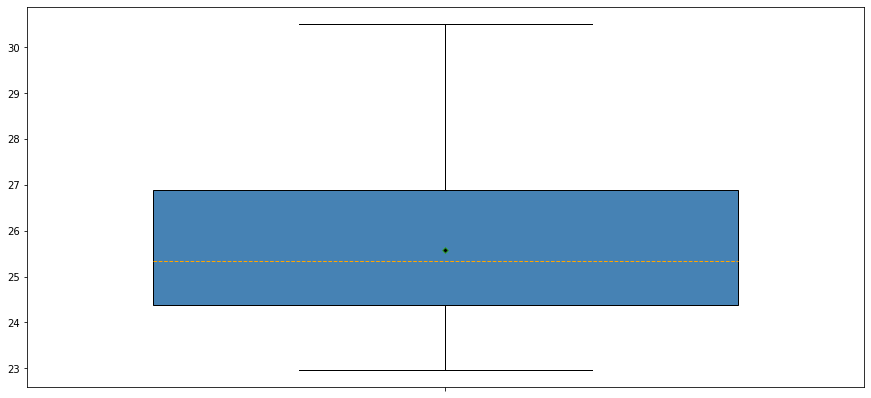

In [165]:
plt.boxplot(x=predicted_traffic,whis = 20,widths = 0.7,patch_artist = True,showmeans = True,boxprops = {'facecolor':'steelblue'}
            ,flierprops = {'markerfacecolor':'red', 'markeredgecolor':'red', 'markersize':4}
            ,meanprops = {'marker':'D','markerfacecolor':'black', 'markersize':4}
            ,medianprops = {'linestyle':'--','color':'orange'},labels = [''])



plt.show


In [166]:
for i in range(predicted_traffic.shape[0]-20):
    #print(i,i+20)
    max_value = np.max(np.percentile(predicted_traffic[i:i+20], (25, 50, 99), interpolation='midpoint'))
    if max_value >= 30:
        print(max_value)

30.311609268188477
30.311609268188477
30.31193733215332
30.31666374206543
30.318483352661133
30.319111824035645
30.319278717041016
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.319281578063965
30.132283210754395
30.132283210754395
30.132283210754395
30.132283210754395
30.132283210754395
30.132283210754395
30.132283210754395
30.13224697113037
30.132166862487793
30.132097244262695
30.13205051422119
30.1320219039917
30.13200569152832
30.131997108459473
30.13199234008789
30.131990432739258
30.13198947906494
30.131988525390625
